##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - Batch Mode

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Batch_mode.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

[Batch Mode](https://ai.google.dev/gemini-api/docs/batch-mode) is designed for processing large volumes of non-latency-critical requests asynchronously. It's ideal for workloads that require high throughput, such as pre-processing datasets, running large-scale evaluations, or generating content in bulk.

**Key Benefits:**
*   **High throughput:** Process millions of requests in a single job.
*   **Cost savings:** Batches are priced at a 50% discount compared to the standard API.
*   **Asynchronous:** Submit your job and retrieve the results later, within a 24-hour SLO.

**In this notebook, you will learn how to:**
1.  Set up your environment for Batch Mode.
2.  Create a batch job by uploading a JSONL file (recommended for large jobs).
3.  Create a batch job using inline requests (convenient for smaller jobs).
4.  Monitor the status of your job.
5.  Retrieve and parse the results for both job types.
6.  Manage your jobs (list and cancel).

# Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [1]:
%pip install -q -U "google-genai>=1.0.0"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [2]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [3]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY,http_options={'api_version': 'v1alpha'})

### Choose a model

Most Gemini models are compatible with Batch mode, but the size of the queue is not the same for each of them. Refer to the [documentation](https://ai.google.dev/gemini-api/docs/batch-mode#technical-details) for more details.

In [4]:
MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.0-flash", "gemini-2.0-flash-preview-image-generation"] {"allow-input":true, isTemplate: true}

Media gen models ([Imagen](./Get_started_imagen.ipynb), [Lyria](./Get_started_LyriaRealTime.ipynb) or [Veo](./Get_started_Veo.ipynb)) are not currently compatible with Batch API. But if you want to batch create images you can use the [Gemini 2.0 Flash Preview Image Generation](./Image_out.ipynb) model (see example below).

# Creating Batch Jobs: Two Methods

You can create batch jobs in two ways:

1.  **File-based (`src`)**: Upload a JSONL file containing all your requests. This is the recommended method for large datasets.
2.  **Inline (`inlined_requests`)**: Pass a list of request objects directly in your code. This is convenient for smaller, dynamically generated jobs.


## Create a job from a file

This is the most common workflow. You will prepare an input file, upload it, create the job, monitor it, and retrieve the results.

### Step 1: Prepare and upload the input File

The input file must be a **JSON** file, where each line is a JSON object. Each object must contain a unique `key` to help you correlate inputs with outputs, and a `request` object matching the `GenerateContentRequest` schema.

In [ ]:
# Create a sample JSONL file.
# The 'key' field is required for correlating inputs to outputs.

import json

requests_data = [
    {"key": "request_1", "request": {"contents": [{"parts": [{"text": "Explain how AI works in a few words"}]}]}},
    {"key": "request_2", "request": {"contents": [{"parts": [{"text": "Explain how quantum computing works in a few words"}]}]}}
]

json_file_path = 'batch_requests.json'

with open(json_file_path, 'w') as f:
    for req in requests_data:
        f.write(json.dumps(req) + '\n')

# 2. Upload JSONL file to File API.
print(f"Uploading file: {json_file_path}")
uploaded_batch_requests = client.files.upload(
    file=json_file_path,
    config=types.UploadFileConfig(display_name='batch-input-file')
)
print(f"Uploaded file: {uploaded_batch_requests.name}")

Uploading file: batch_requests.json
Uploaded file: files/p1mds9fl15bs


### Step 2: Create the Batch Job

Now, pass the uploaded file's name (`uploaded_batch_requests.name`) to the `client.batches.create` function to create the batch job.

In [ ]:
batch_job_from_file = client.batches.create(
    model=MODEL_ID,
    src=uploaded_batch_requests.name,
    config={
        'display_name': 'my-batch-job-from-file',
    }
)
print(f"Created batch job from file: {batch_job_from_file.name}")

Created batch job from file: batches/o08hk76gv328ihxcssjsgwt3g6omtfysxi46


### Step 3: Monitor job status

Jobs can take time to complete (up to 24 hours). You can poll the API to check the status.

In [ ]:
# Note: You can check the status of any job by replacing its name here.
# For example: job_name = 'batches/your-job-name-here'

import time

job_name = batch_job_from_file.name

print(f"Polling status for job: {job_name}")

# Poll the job status until it's completed.
while True:
    batch_job = client.batches.get(name=job_name)
    if batch_job.state.name in ('JOB_STATE_SUCCEEDED', 'JOB_STATE_FAILED', 'JOB_STATE_CANCELLED'):
        break
    print(f"Job not finished. Current state: {batch_job.state.name}. Waiting 30 seconds...")
    time.sleep(30)

print(f"Job finished with state: {batch_job.state.name}")
if batch_job.state.name == 'JOB_STATE_FAILED':
    print(f"Error: {batch_job.error}")

Polling status for job: batches/o08hk76gv328ihxcssjsgwt3g6omtfysxi46
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_PENDING. Waiting 30 seconds...
Job finished with state: JOB_STATE_SUCCEEDED


### Step 4: Retrieve and parse results

Once a file-based job succeeds, the results are written to an output file in the [Files API](./File_API.ipynb).

In [ ]:
if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
    # The output is in another file.
    result_file_name = batch_job.dest.file_name
    print(f"Results are in file: {result_file_name}")

    print("\nDownloading and parsing result file content...")
    file_content_bytes = client.files.download(file=result_file_name)
    file_content = file_content_bytes.decode('utf-8')

    # The result file is also a JSONL file. Parse and print each line.
    for line in file_content.splitlines():
      if line:
        parsed_response = json.loads(line)
        # Pretty-print the JSON for readability
        print(json.dumps(parsed_response, indent=2))
        print("-" * 20)
else:
    print(f"Job did not succeed. Final state: {batch_job.state.name}")

Results are in file: files/batch-o08hk76gv328ihxcssjsgwt3g6omtfysxi46

{
  "response": {
    "responseId": "6VFkaIDwEPXVjMcP4-XW6Qo",
    "usageMetadata": {
      "totalTokenCount": 848,
      "promptTokensDetails": [
        {
          "modality": "TEXT",
          "tokenCount": 8
        }
      ],
      "thoughtsTokenCount": 829,
      "candidatesTokenCount": 11,
      "promptTokenCount": 8
    },
    "candidates": [
      {
        "content": {
          "role": "model",
          "parts": [
            {
              "text": "AI learns patterns from data to make decisions or predictions."
            }
          ]
        },
        "finishReason": "STOP",
        "index": 0
      }
    ],
    "modelVersion": "gemini-2.5-flash"
  },
  "key": "request_1"
}
--------------------
{
  "response": {
    "modelVersion": "gemini-2.5-flash",
    "candidates": [
      {
        "index": 0,
        "finishReason": "STOP",
        "content": {
          "role": "model",
          "parts": [

## Alternative: Create a job with inline requests

For smaller tasks, you can pass requests directly without creating a file. The results will be returned directly in the job object itself.

### Step 1: Create and monitor the inline job

In [ ]:
# 1. Define your list of requests.
# Note: Unlike the file-based method, a 'key' is not required for inline requests,
# as the order of responses will match the order of requests.
inline_requests_list = [
    {'contents': [{'parts': [{'text': 'Write a short poem about a cloud.'}]}]},
    {'contents': [{'parts': [{'text': 'Write a short poem about a cat.'}]}]}
]

# 2. Create the batch job with the inline requests.
print("Creating inline batch job...")
batch_job_inline = client.batches.create(
    model=MODEL_ID,
    src=inline_requests_list,
    config={'display_name': 'my-batch-job-inline-example'}
)
print(f"Created inline batch job: {batch_job_inline.name}")
print("-" * 20)

# 3. Monitor the job until completion.
job_name = batch_job_inline.name
print(f"Polling status for job: {job_name}")

while True:
    batch_job_inline = client.batches.get(name=job_name)
    if batch_job_inline.state.name in ('JOB_STATE_SUCCEEDED', 'JOB_STATE_FAILED', 'JOB_STATE_CANCELLED'):
        break
    print(f"Job not finished. Current state: {batch_job.state.name}. Waiting 30 seconds...")
    time.sleep(30)

print(f"Job finished with state: {batch_job.state.name}")
if batch_job.state.name == 'JOB_STATE_FAILED':
    print(f"Error: {batch_job.error}")

Creating inline batch job...
Created inline batch job: batches/mqnrj9gul3irzwwy4vgawrv9w40vxbvou6x2
--------------------
Polling status for job: batches/mqnrj9gul3irzwwy4vgawrv9w40vxbvou6x2
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEEDED. Waiting 30 seconds...
Job not finished. Current state: JOB_STATE_SUCCEED

### Step 2: Retrieve and print inline results
Once the job has succeeded, the results are available in the inlined_responses field of the job object. You can iterate through this list to get each response.

In [ ]:
if batch_job_inline.state.name == 'JOB_STATE_SUCCEEDED':
    print("\nResults are inline:")
    # The results are in the `inlined_responses` field.
    for i, inline_response in enumerate(batch_job_inline.dest.inlined_responses):
        print(f"\n--- Response {i+1} ---")

        # Check for a successful response
        if inline_response.response:
            # The .text property is a shortcut to the generated text.
            try:
                print(inline_response.response.text)
            except AttributeError:
                # Fallback to printing the full response if .text isn't available
                print(inline_response.response)

        # Check for an error in this specific request
        elif inline_response.error:
            print(f"Error: {inline_response.error}")

else:
    print(f"Job did not succeed. Final state: {batch_job_inline.state.name}")
    if batch_job_inline.error:
        print(f"Error: {batch_job_inline.error}")


Results are inline:

--- Response 1 ---
A fluffy, soft white sight,
It drifts with gentle light.
Across the sky so blue,
A changing, dreamy view.

--- Response 2 ---
A silent step, a velvet paw,
He naps, ignoring every law.
A sudden stretch, a sleepy blink,
Then purrs, much deeper than you think.


## Managing jobs

Here are some common operations for managing your batch jobs.

### List your batch jobs

#### List Recent Jobs

In [ ]:
print("Listing recent batch jobs:\n")

# Note: The list API currently doesn't return inlined_responses.
# As a workaround,you can make a `get` call for inline jobs to see their results.
batches = client.batches.list(config={'page_size': 10})

for b in batches.page:
    print(f"Job Name: {b.name}")
    print(f"  - Display Name: {b.display_name}")
    print(f"  - State: {b.state.name}")
    print(f"  - Create Time: {b.create_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Check if it was an inline job (no destination file)
    if b.dest is not None:
      if not b.dest.file_name:
        full_job = client.batches.get(name=b.name)
        if full_job.inlined_responses:
            print("  - Type: Inline ({} responses)".format(len(full_job.inlined_responses)))
      else:
          print(f"  - Type: File-based (Output: {b.dest.file_name})")

    print("-" * 20)

Listing recent batch jobs:

Job Name: batches/mqnrj9gul3irzwwy4vgawrv9w40vxbvou6x2
  - Display Name: my-batch-job-inline-example
  - State: JOB_STATE_SUCCEEDED
  - Create Time: 2025-07-01 21:24:08
--------------------
Job Name: batches/o08hk76gv328ihxcssjsgwt3g6omtfysxi46
  - Display Name: my-batch-job-from-file
  - State: JOB_STATE_SUCCEEDED
  - Create Time: 2025-07-01 21:19:34
  - Type: File-based (Output: files/batch-o08hk76gv328ihxcssjsgwt3g6omtfysxi46)
--------------------
Job Name: batches/7y78ioanoiaatpx7skou4bj9qo4xqv97p2cf
  - Display Name: my-batch-image-gen-job
  - State: JOB_STATE_SUCCEEDED
  - Create Time: 2025-07-01 20:50:48
  - Type: File-based (Output: files/batch-7y78ioanoiaatpx7skou4bj9qo4xqv97p2cf)
--------------------
Job Name: batches/pd6qbrq4izis2xzc653uczycn2wu2at6hdw4
  - Display Name: my-batch-job-with-image
  - State: JOB_STATE_SUCCEEDED
  - Create Time: 2025-07-01 20:50:43
  - Type: File-based (Output: files/batch-pd6qbrq4izis2xzc653uczycn2wu2at6hdw4)
-------

#### Cancel a Batch Job (Optional)

If you need to stop a job that is still pending or running, you can cancel it.

#### Cancel a Job
The next cell is commented out to prevent accidental cancellation.

To use it:
1. Get the name of the job you want to cancel (e.g., from the list above).
2. Uncomment the code and replace the placeholder name.

In [ ]:
# try:
#   job_to_cancel_name = "batches/your-job-name-here" # <-- REPLACE THIS
#   print(f"Attempting to cancel job: {job_to_cancel_name}")
#   client.batches.cancel(name=job_to_cancel_name)
#   print("Job cancellation request sent.")
# except Exception as e:
#   print(f"Error cancelling job: {e}")

## Other examples

### Using multimodal input
Here's an example using multimodal input. Once again it will use the [Files API](./File_API.ipynb) to store the image you want to send along with your prompts.

Uploading image file: jetpack.jpg
Uploaded image file: files/sm3dyq4g4zqy with MIME type: image/jpeg


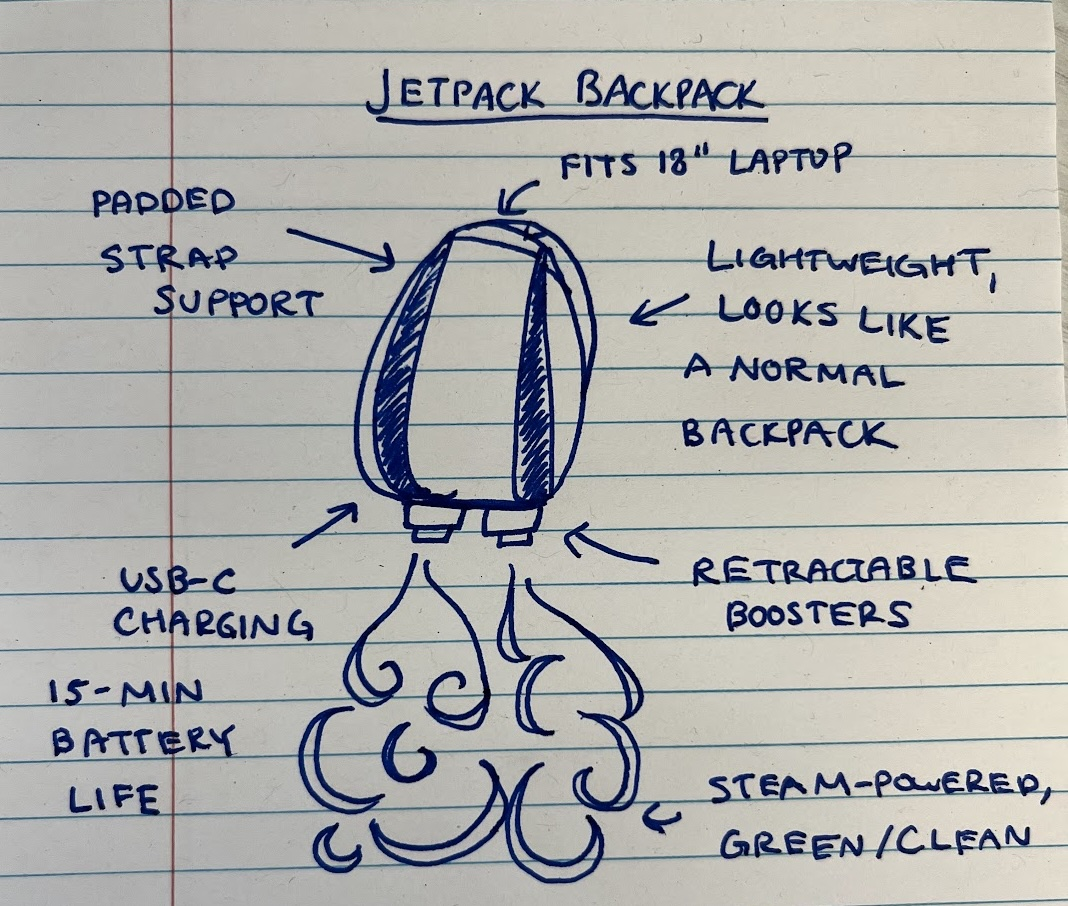

In [ ]:
# Download sample image

from IPython.display import Image

image_path = "jetpack.jpg"
!wget https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg -O {image_path}  -q

print(f"Uploading image file: {image_path}")
image_file = client.files.upload(
    file=image_path,
)
print(f"Uploaded image file: {image_file.name} with MIME type: {image_file.mime_type}")
Image(filename=image_path)

In [ ]:
requests_data = [
    # First request: simple text prompt
    {"key": "request_1", "request": {"contents": [{"parts": [{"text": "Explain how AI works in a few words"}]}]}},
    # Second request: multi-modal prompt with text and an image reference
    {
        "key": "request_2_image",
        "request": {
            "contents": [{
                "parts": [
                    {"text": "What is in this image? Describe it in detail."},
                    {"file_data": {"file_uri": image_file.uri, "mime_type": image_file.mime_type}}
                ]
            }]
        }
    }
]


json_file_path = 'batch_requests_with_image.json'

print(f"\nCreating JSONL file: {json_file_path}")
with open(json_file_path, 'w') as f:
    for req in requests_data:
        f.write(json.dumps(req) + '\n')

print(f"Uploading JSONL file: {json_file_path}")
batch_input_file = client.files.upload(
    file=json_file_path
    )
print(f"Uploaded JSONL file: {batch_input_file.name}")

print("\nCreating batch job...")
batch_job_from_file = client.batches.create(
    model=MODEL_ID,
    src=batch_input_file.name,
    config={
        'display_name': 'my-batch-job-with-image',
    }
)
print(f"Created batch job from file: {batch_job_from_file.name}")
print("You can now monitor the job status using its name.")


Creating JSONL file: batch_requests_with_image.json
Uploading JSONL file: batch_requests_with_image.json
Uploaded JSONL file: files/hq429pdc5pfk

Creating batch job...
Created batch job from file: batches/3ar0jhcayt8o9gixe3nv22xdsxooh0ednsi6
You can now monitor the job status using its name.


In [ ]:
batch_job_from_file = client.batches.get(name=batch_job_from_file.name)
if batch_job_from_file.state.name == 'JOB_STATE_SUCCEEDED':
    # The output is in another file.
    result_file_name = batch_job_from_file.dest.file_name
    print(f"Results are in file: {result_file_name}")

    print("\nDownloading and parsing result file content...")
    file_content_bytes = client.files.download(file=result_file_name)
    file_content = file_content_bytes.decode('utf-8')

    # The result file is also a JSONL file. Parse and print each line.
    for line in file_content.splitlines():
      if line:
        parsed_response = json.loads(line)
        # Pretty-print the JSON for readability
        print(json.dumps(parsed_response['response']['candidates'][0]['content'], indent=2))
        print("-" * 20)
else:
    print(f"Job did not succeed. Final state: {batch_job_from_file.state.name}")

Results are in file: files/batch-3ar0jhcayt8o9gixe3nv22xdsxooh0ednsi6

{
  "parts": [
    {
      "text": "AI learns from data to identify patterns and make decisions."
    }
  ],
  "role": "model"
}
--------------------
{
  "role": "model",
  "parts": [
    {
      "text": "The image displays a detailed, hand-drawn conceptual sketch of a \"JETPACK BACKPACK\" on a sheet of white paper with blue horizontal lines, typical of ruled notebook paper. All elements, including the drawing and text, are rendered in blue ink, giving it the appearance of a casual brainstorming or design note.\n\nAt the top of the page, the title **\"JETPACK BACKPACK\"** is prominently displayed, underlined and written in bold capital letters.\n\nThe central feature is a stylized drawing of a backpack, depicted from a slightly elevated, possibly three-quarter, angle, showing its top and front/sides. It has a rounded, somewhat oval shape, wider at the top and tapering slightly towards the bottom. The front of the ba

### Multimodal output
This time you're going to batch generate images using the [Gemini 2.0 Flash Preview Image Generation](https://ai.google.dev/gemini-api/docs/image-generation#gemini) model. More details on the [dedicated notebook](./Image_out.ipynb).

In [6]:
requests_data = [
    {"key": "image_request_1", "request": {"contents": [{"parts": [{"text": "A big letter A surrounded by animals starting with the A letter"}]}],'generation_config': {'response_modalities': ['TEXT', 'IMAGE']}}}, # Be careful, for inline request it would be 'config' instead of 'generation_config'
    {"key": "image_request_2", "request": {"contents": [{"parts": [{"text": "A big letter B surrounded by animals starting with the B letter"}]}],'generation_config': {'response_modalities': ['TEXT', 'IMAGE']}}},
]

json_file_path = 'batch_image_gen_requests.json'

print(f"\nCreating JSONL file: {json_file_path}")
with open(json_file_path, 'w') as f:
    for req in requests_data:
        f.write(json.dumps(req) + '\n')

print(f"Uploading JSONL file: {json_file_path}")
batch_input_file = client.files.upload(
    file=json_file_path
    )
print(f"Uploaded JSONL file: {batch_input_file.name}")

print("\nCreating batch job...")
batch_multimodal_job = client.batches.create(
    model="gemini-2.0-flash-preview-image-generation",
    src=batch_input_file.name,
    config={
        'display_name': 'my-batch-image-gen-job',
    }
)
print(f"Created batch job from file: {batch_multimodal_job.name}")
print("You can now monitor the job status using its name.")


Creating JSONL file: batch_image_gen_requests.json
Uploading JSONL file: batch_image_gen_requests.json
Uploaded JSONL file: files/4k1cfn983f0a

Creating batch job...
Created batch job from file: batches/6czrv8tda2rbsvn7gno27npxly1pyv5xjjh2
You can now monitor the job status using its name.


Results are in file: files/batch-6czrv8tda2rbsvn7gno27npxly1pyv5xjjh2



I will generate an image of a large, stylized letter A. Surrounding this letter will be a diverse collection of animals whose names begin with the letter "A," such as an alligator, an ant, an anteater, an ape, an armadillo, and possibly others, arranged in a visually appealing and balanced composition around the central letter.



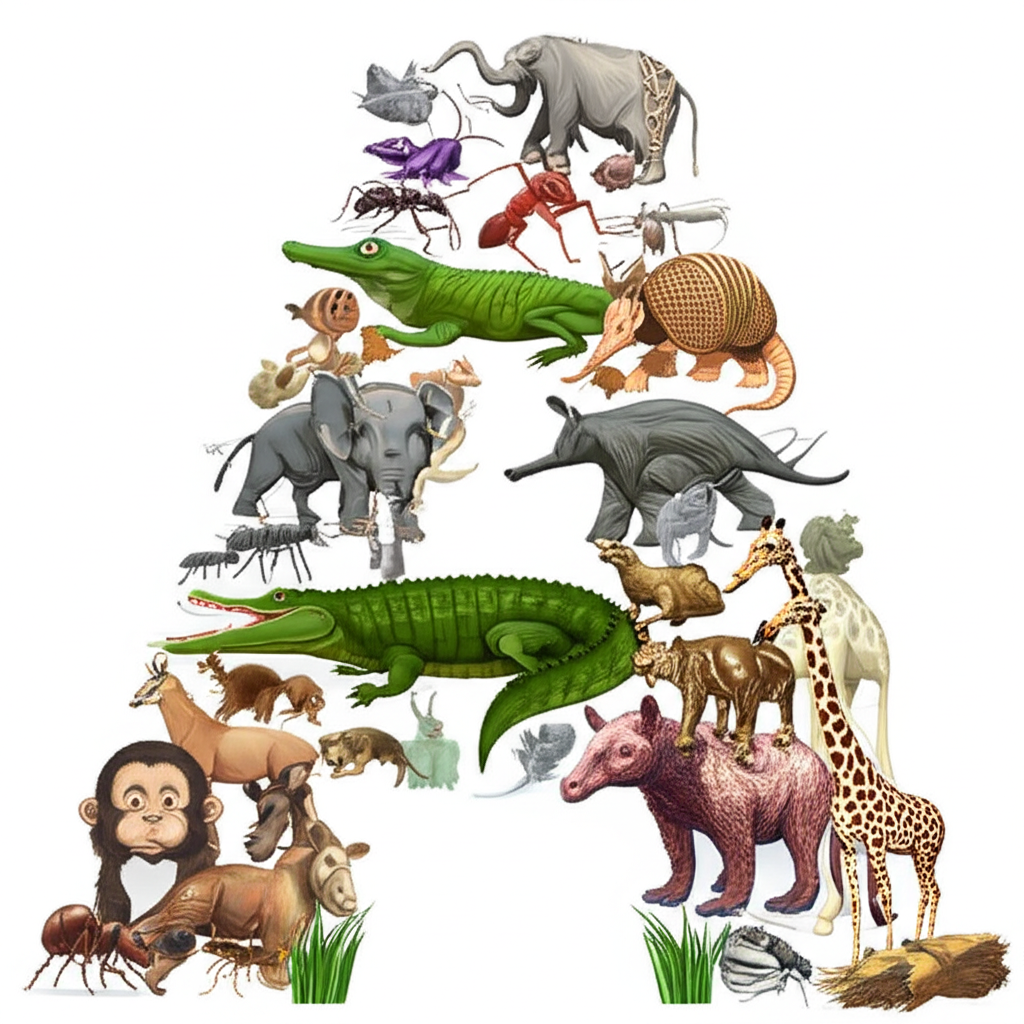

I will generate an image of a large, uppercase letter B rendered in a vibrant color, such as deep blue, positioned centrally in the frame. Surrounding this letter will be various animals whose names begin with the letter 'B'. These will include a fluffy brown bear, a bright bluebird perched on top of the 'B', a small brown bunny sitting at the base, a colorful butterfly fluttering nearby, and perhaps a playful badger peeking out from behind the letter. The animals will be depicted in a cartoonish and friendly style.

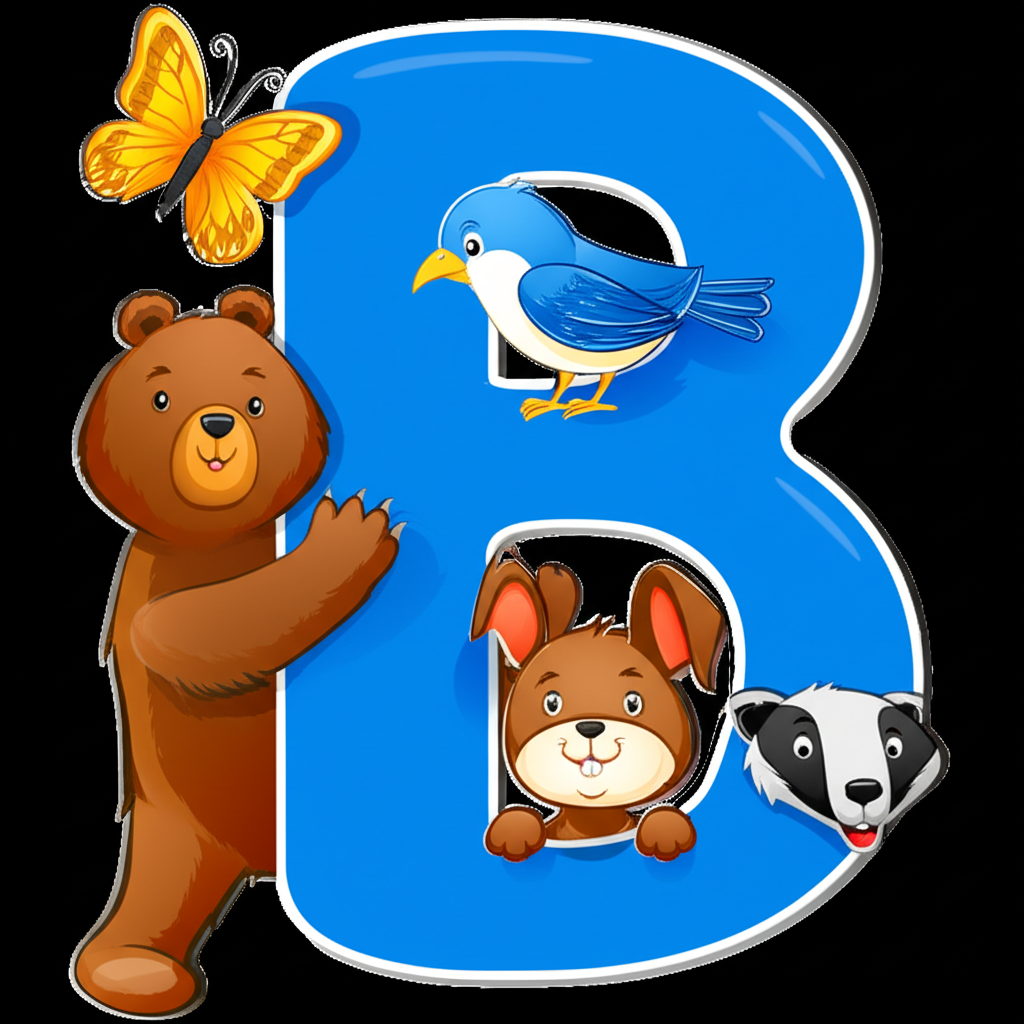

In [8]:
from IPython.display import display, Markdown, Image
import base64

batch_multimodal_job = client.batches.get(name=batch_multimodal_job.name)

if batch_multimodal_job.state.name == 'JOB_STATE_SUCCEEDED':
    # The output is in another file.
    result_file_name = batch_multimodal_job.dest.file_name
    print(f"Results are in file: {result_file_name}")

    print("\nDownloading and parsing result file content...")
    file_content_bytes = client.files.download(file=result_file_name)
    file_content = file_content_bytes.decode('utf-8')

    # The result file is also a JSONL file. Parse and print each line.
    for line in file_content.splitlines():
      if line:
        parsed_response = json.loads(line)
        for part in parsed_response['response']['candidates'][0]['content']['parts']:
          if part.get('text'):
            display(Markdown(part['text']))
          elif part.get('inlineData'):
            mime = part['inlineData']['mimeType']
            data = base64.b64decode(part['inlineData']['data'])
            display(Image(data=data, format=mime.split('/')[-1]))
else:
    print(f"Job did not succeed. Final state: {batch_multimodal_job.state.name}")

The output could not be saved in the notebook but here's what it could look like:
![Letter A](https://storage.googleapis.com/generativeai-downloads/images/letter_A.jpeg)

![Letter B](https://storage.googleapis.com/generativeai-downloads/images/letter_B.jpeg)

## Next Steps
### Useful API references:

For more details on Batch mode, please check the related [documentation](https://ai.google.dev/gemini-api/docs/batch-mode).

### Continue your discovery of the Gemini API

Check other nice Gemini capabilities in the [Cookbook](https://github.com/google-gemini/cookbook/). In particular, the [quickstarts](https://github.com/google-gemini/cookbook/quickstarts) folder is full of guides on how to use the Gemini (and gen-media) models and features, while the [example](https://github.com/google-gemini/cookbook/examples) folder showcase coiol use-cases to spark your creativity.
